# TJC Free Text Analysis

<B>Clustering Technique:</B> Affinity Propogation
<B>Distance Metric:</B> Cosine
<B>Feature Engineering:</B>
- NLTK Stopwords Removed
- Limited Plural & Singular Reconciliation
- Modified Bi-Gram technique that considers punctuation
- DF_Min = 2

Before beginning download the latest survey dataset from the TJC FTP site - 'TJC_Survey_Findings.xlsx'

If a processing issue occurs, particularly toward the beginning of the year, check to ensure the file schema has not changed.

In [ ]:
#Import All Libraries

#Base Libraries
import pandas
import numpy
import re
import operator

#Data Science Libraries
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer

#Other Libraries
import logging
from time import localtime, strftime  #Used for Performanace Analysis
import matplotlib.pyplot as plt #REMOVE FOR PRODUCTION
%matplotlib inline #REMOVE FOR PRODUCTION

#Reset Dataframe Visuals
pandas.set_option('max_colwidth',100) #REMOVE FOR PRODUCTION

### Load in the latest data for analysis (ETL)

In [2]:
#Get existing data that was previously previously processed
print("Loading existing survey data...",end="", flush=True)

dataset_historical_OrgsSurveyed = pandas.read_excel('TJC_Survey_Findings_Historical.xlsx', sheetname = 'OrgsSurveyed')
print("..",end="", flush=True)

dataset_historical_StdandEPDetail = pandas.read_excel('TJC_Survey_Findings_Historical.xlsx', sheetname = 'StdandEPDetail')

print("  Done")
print("Number of Surveys:      ", len(dataset_historical_OrgsSurveyed))
print("Number of Observations: ", len(dataset_historical_StdandEPDetail))

Loading existing survey data.....  Done
Number of Surveys:       610
Number of Observations:  7451


In [3]:
#Get latest data using data downloaded from TJC FTP site
print("Loading most recent survey data...", end="", flush=True)
dataset_current_OrgsSurveyed = pandas.read_excel('TJC_Survey_Findings.xlsx', sheetname = 'OrgsSurveyed')
print("..",end="", flush=True)
dataset_current_StdandEPDetail = pandas.read_excel('TJC_Survey_Findings.xlsx', sheetname = 'StdandEPDetail')
print("  Done")

Loading most recent survey data.....  Done


In [4]:
#Confirm columns match
print("Validating column alignment...")
if max(dataset_historical_OrgsSurveyed.columns == dataset_current_OrgsSurveyed.columns):
    print("Table: OrgSurveyed - VALID")
else:
    print("Table: OrgSurveyed - NOT VALID")

if max(dataset_historical_StdandEPDetail.columns == dataset_current_StdandEPDetail.columns):
    print("Table: StdandEPDetail - VALID")
else:
    print("Table: StdandEPDetail - NOT VALID")
    
## Kill process and throw off code if these do not align

Validating column alignment...
Table: OrgSurveyed - VALID
Table: StdandEPDetail - VALID


In [5]:
####################################
# For reference only:
#
# dataset_historical_OrgsSurveyed.columns =  Index(['Organization ID', 'Organization Name', 'Location', 'Survey Start Date',
#       'Survey End Date', 'Program Code', 'Program Name',
#       'Certification  Disease Code', 'Certification  Disease Name',
#       'Event Type', 'TJC Region Group Name', 'TJC Region Name',
#       'Number of Standards Not Compliant', 'surveyor days',
#       'Number of  EPs Not  Compliant', 'Deemed  Program  Surveyed',
#       'program_event_id'],
#      dtype='object')
#
# dataset_historical_StdandEPDetail.columns =  Index(['Organization ID', 'Organization Name', 'City', 'State',
#       'TJC Region Name', 'Program Code', 'Certification  Disease Code',
#       'Event Type', 'Standard Chapter Code', 'Standard Chapter Name',
#       'Standard Text', 'Standard', 'EP', 'Standard and EP',
#       'EP SAFER Placement', 'EP Scope', 'EP Likelihood', 'Survey Start Date',
#       'Survey End Date', 'Survey Year', 'EP Text', 'EP Observations',
#       'program_event_id'],
#      dtype='object')
#
####################################

In [5]:
print("Appending existing dataset with new data...", end="", flush=True)

#Append exisiting dataset with current data
dataset_OrgsSurveyed = dataset_historical_OrgsSurveyed.append(dataset_current_OrgsSurveyed, ignore_index=True)
dataset_StdandEPDetail = dataset_historical_StdandEPDetail.append(dataset_current_StdandEPDetail, ignore_index=True)

#Remove duplicates
dataset_OrgsSurveyed.drop_duplicates(inplace  = True)
dataset_StdandEPDetail.drop_duplicates(inplace  = True)

#Reset indicies
dataset_OrgsSurveyed.reset_index(drop=True, inplace=True)
dataset_StdandEPDetail.reset_index(drop=True,inplace=True)

print("  Done")
print("Number of Surveys:      ", len(dataset_OrgsSurveyed))
print("Number of Observations: ", len(dataset_StdandEPDetail))

Appending existing dataset with new data...  Done
Number of Surveys:       610
Number of Observations:  7451


In [6]:
print("Saving updated dataset for future use...", end="", flush=True)
#Update Data File

#Open an excel file for writing
writer = pandas.ExcelWriter('TJC_Survey_Findings_Historical.xlsx')
print("..", end="", flush=True)

#Pass through survey metadata
dataset_OrgsSurveyed.to_excel(writer,'OrgsSurveyed',index=False)
print("..", end="", flush=True)
dataset_StdandEPDetail.to_excel(writer,'StdandEPDetail',index=False)
print("..", end="", flush=True)

#Save the excel file
writer.save()

print("  Done")

Saving updated dataset for future use.........  Done


In [7]:
print("Preparing dataset for preprocessing...", end="", flush=True)

#Pass data for processing
dataset = dataset_StdandEPDetail.copy(deep = True)

#Replace Spaces in Column Names
dataset.columns = dataset.columns.str.translate({ord(c): '_' for c in ' '})

print("  Done")

Preparing dataset for preprocessing...  Done


### Preprocess - Reconcile Plural & Sigular forms of words

In [8]:
print("\nPREPROCESS - CREATE DICTIONARY OF PLURAL WORDS TO REPLACE\n")
print("Preparing observation data...", end="", flush=True)

#Add Column for processing text
dataset['EP_Observations_proc'] = dataset.EP_Observations.astype(str)
print("..", end="", flush=True)

#Clean up the descriptions for processing
dataset.EP_Observations_proc = dataset.EP_Observations_proc.apply(lambda x:re.sub(r'[^a-zA-Z_ ]',r'',x)).str.lower() #Pass only letters
dataset.EP_Observations_proc = dataset.EP_Observations_proc.apply(lambda x:re.sub(r'\s+', r' ',x)) #Trim whitespace
print("..", end="", flush=True)

#Remove stopwords
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
dataset.EP_Observations_proc = dataset.EP_Observations_proc.apply(lambda x:pattern.sub('', x))
print("  Done", end="", flush=True)



PREPROCESS - CREATE DICTIONARY OF PLURAL WORDS TO REPLACE

Preparing observation data.......  Done

In [9]:
print("Identifying words existing in both plural and sigular form...")

#Get remaining words
word_list = list(set([item for sublist in dataset.EP_Observations_proc.str.split() for item in sublist]))

#Naive search for plural words ending in "s" or "es"

#Note: If these is no single form found, there is no match and therefore no transformation since it is not neccessary

word_set = pandas.Series(word_list)
word_plural = pandas.Series()
word_plural_single = pandas.Series()

progress_target = len(word_set.index.values)
progress_current = 0
print(('%.1f%%' %(100.0*progress_current/progress_target)).rjust(6) + ' Complete', end = "")

for idx in word_set.index.values:
    if word_set.loc[idx][-1:] == 's':
        if len(word_set.loc[idx]) > 3:
            if max(word_set == word_set.loc[idx][:-1]):
                word_plural = word_plural.append(pandas.Series(word_set.loc[idx] , index = [idx]))
                word_plural_single = word_plural_single.append(pandas.Series(word_set.loc[idx][0:-1] , index = [idx]))
                word_set.drop(idx,inplace=True)
    elif word_set.loc[idx][-2:] == 'es':
        if len(word_set.loc[idx]) > 4:
            if max(word_set == word_set.loc[idx][:-2]):
                word_plural = word_plural.append(pandas.Series(word_set.loc[idx] , index = [idx]))
                word_plural_single = word_plural_single.append(pandas.Series(word_set.loc[idx][0:-2] , index = [idx]))
                word_set.drop(idx,inplace=True)
    
    progress_current += 1
    print('\r' + ('%.1f%%' %(100.0*progress_current/progress_target)).rjust(6) + ' Complete', end = "")


#Build dictionary with plural words matching single form
print('\n\nBuilding dictionary of plural words to convert to singular form...')
progress_target = len(word_plural_single.index.values)
progress_current = 0
print(('%.1f%%' %(100.0*progress_current/progress_target)).rjust(6) + ' Complete', end = "")

word_mod = {}

for idx in word_plural_single.index.values:
    if len(word_set[word_set == word_plural_single[idx]].values) > 0:
        word_mod.update({word_plural[idx] : ''.join(word_set[word_set == word_plural_single[idx]].values)})
    progress_current += 1
    print('\r' + ('%.1f%%' %(100.0*progress_current/progress_target)).rjust(6) + ' Complete', end = "")

#Check results
print('\n\nNumber of unique plural words to be converted: ', len(word_mod))
print('Test word: schedules -->', word_mod.get('schedules'))
print('Test word: doors -->', word_mod.get('doors'))
print('Preprocessing Complete')

Identifying words existing in both plural and sigular form...
100.0% Complete

Building dictionary of plural words to convert to singular form...
100.0% Complete

Number of unique plural words to be converted:  1256
Test word: schedules --> schedule
Test word: doors --> door
Preprocessing Complete


### Prep Free Text for Analysis

In [10]:
print('\nPREPROCESS - PREP FREE TEXT FOR ANALYSIS\n')

#Bi-Gram Function - Concatinate adjacent words for naive context
#Note:  It would be nice to find a fully supported function here
def word_seq(orig_text):
    new_string_list = []
    orig_string_list = orig_text.split()
    for idx in range(0,len(orig_string_list)-1):
        new_string_list += ['{:s}_{:s}'.format(orig_string_list[idx],orig_string_list[idx+1])]
    output = ' '.join(new_string_list)
    return(' ' + output.strip())


PREPROCESS - PREP FREE TEXT FOR ANALYSIS



In [11]:
print("Preparing observation data...", end="", flush=True)

#Reset Column for processing text
dataset['EP_Observations_proc'] = dataset.EP_Observations.astype(str)
print('..', end='', flush=True)

# TEST DATAPOINT - dataset.EP_Observations_proc.iloc[308]

#Clean up the descriptions for processing
dataset.EP_Observations_proc = dataset.EP_Observations_proc.apply(lambda x:re.sub(r'[^a-zA-Z_ \.,\;]',r' ',x)).str.lower() #Pass only characters as well as punctuation that act as seperators
print('..', end='', flush=True)
dataset.EP_Observations_proc = dataset.EP_Observations_proc.apply(lambda x:re.sub(r'\s+', r' ',x)) #Trim whitespace

print('  Done')

Preparing observation data.......  Done


In [14]:
# TEST DATAPOINT - dataset.EP_Observations_proc.iloc[308]

In [12]:
#Convert plural words to single form

print("Reconciling plural and singular words...")

progress_target = len(word_mod)
progress_current = 0
print(('%.1f%%' %(100.0*progress_current/progress_target)).rjust(6) + ' Complete', end = "")

for key, value in word_mod.items():
    dataset.EP_Observations_proc = dataset.EP_Observations_proc.apply(lambda x:re.sub(r'\b%s\b' % key, value, x))

    progress_current += 1
    print('\r' + ('%.1f%%' %(100.0*progress_current/progress_target)).rjust(6) + ' Complete', end = "")


Reconciling plural and singular words...
100.0% Complete

In [13]:
# TEST DATAPOINT - dataset.EP_Observations_proc.iloc[308]

In [14]:
print('Implementing bi-gram function...', end ='', flush = True)

#Replace stopwords & punctuation with "X"
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
dataset.EP_Observations_proc = dataset.EP_Observations_proc.apply(lambda x:pattern.sub(' X ', x))
print('..', end = '', flush = True)
dataset.EP_Observations_proc = dataset.EP_Observations_proc.apply(lambda x:re.sub(r'[\.,\;]', ' X ', x))
print('..', end = '', flush = True)

#Replace any word of 1 character with "X"
dataset.EP_Observations_proc = dataset.EP_Observations_proc.apply(lambda x:re.sub(r'\b\w{1,1}\b', r'X', x))
print('..', end = '', flush = True)

#Attach bi-grams to description
dataset['word_seq'] = dataset.EP_Observations_proc.apply(lambda x:word_seq(x))
print('..', end = '', flush = True)
dataset.EP_Observations_proc = dataset.EP_Observations_proc + dataset.word_seq
dataset.drop(axis=1, labels=['word_seq'], inplace = True)
print('..', end = '', flush = True)

# TEST DATAPOINT - dataset.EP_Observations_proc.iloc[308]

#Remove items containing "X^"
dataset.EP_Observations_proc = dataset.EP_Observations_proc.apply(lambda x:re.sub(r'\bX_X\b', r' ',x)) #Remove "X_X"
print('..', end = '', flush = True)
dataset.EP_Observations_proc = dataset.EP_Observations_proc.apply(lambda x:re.sub(r'\bX\b', r' ',x)) #Remove "X"
print('..', end = '', flush = True)
dataset.EP_Observations_proc = dataset.EP_Observations_proc.apply(lambda x:re.sub(r'\bX_\S*\b', r' ',x)) #Remove "X_word"
print('..', end = '', flush = True)
dataset.EP_Observations_proc = dataset.EP_Observations_proc.apply(lambda x:re.sub(r'\b\S*_X\b', r' ',x)) #Remove "word_X"
print('..', end = '', flush = True)
dataset.EP_Observations_proc = dataset.EP_Observations_proc.apply(lambda x:re.sub(r'\s+', r' ',x)) #Trim Whitespace

print('  Done')
print('PREPROCESSING - COMPLETE')

Implementing bi-gram function.....................  Done
PREPROCESSING - COMPLETE


In [15]:
# TEST DATAPOINT - dataset.EP_Observations_proc.iloc[308]

### TF-IDF processing

In [16]:
#TF-IDF
print('Creating TFIDF matrix...', end ='', flush = True)

vectorizer = TfidfVectorizer(stop_words='english', min_df = 2)
X = vectorizer.fit_transform(dataset['EP_Observations_proc'])
print('  Done')

#Use Cosine Similarity since entries are of varying lengths
#We want to avoid basing toward longer entries

print('Calculating cosine distances...', end ='', flush = True)

base_tfidf = cosine_similarity(X)

print('  Done')

Creating TFIDF matrix...  Done
Calculating cosine distances...  Done


In [17]:
# len(vectorizer.vocabulary_)

### Build clustering model

In [18]:
print('Building cluster model... (This may take some time.)')
print(strftime("%Y-%m-%d %H:%M:%S", localtime()))

#Run propagation model
model = AffinityPropagation(damping=0.9, max_iter=500, convergence_iter=15, copy=True, preference=None, affinity='precomputed', verbose=True)
model.fit(base_tfidf)

print(strftime("%Y-%m-%d %H:%M:%S", localtime()))

Building cluster model... (This may take some time.)
2018-08-30 11:07:33
Converged after 377 iterations.
2018-08-30 11:18:50


In [19]:
#Attach Cluster Labels to Dataset
dataset['cluster_id'] = pandas.Series(model.labels_, dtype = "int32")

In [20]:
#Encode Chapter, Standard, and EP for each observation for analysis

chapter_enc = LabelBinarizer()
chapter_enc.fit(dataset.Standard_Chapter_Code.str.strip())

standard_enc = LabelBinarizer()
standard_enc.fit(dataset.Standard.str.strip())

dataset['Standard_and_EP_mod'] = dataset.Standard_and_EP.str.strip().str.translate({ord(c): '_' for c in ' '}).astype(str)
stdEP_enc = LabelBinarizer()
stdEP_enc.fit(dataset.Standard_and_EP_mod)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [21]:
#Describe each cluster

cluster_no = []
cluster_count = []
cluster_words = []

cluster_chapter_counts = []
cluster_standard_counts = []
cluster_ep_counts = []

clusters = pandas.Series(model.labels_).value_counts().index.tolist()

for i in clusters:
    
    #Describe each cluster with the count and top 20 words
    X_list = X[model.labels_ == i].sum(axis=0).argsort().tolist()[0]
    X_keywords = numpy.array(list(dict(sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))).keys()))
    cluster_no += [i]
    cluster_count += [pandas.Series(model.labels_).value_counts()[i]]
    cluster_words += [', '.join(X_keywords[X_list[-21:-1]].tolist())]
    
    cluster_chapter_counts += [sum(chapter_enc.transform(dataset.Standard_Chapter_Code[dataset.cluster_id==i].str.strip()))]
    cluster_standard_counts += [sum(standard_enc.transform(dataset.Standard[dataset.cluster_id==i].str.strip()))]
    cluster_ep_counts += [sum(stdEP_enc.transform(dataset.Standard_and_EP_mod[dataset.cluster_id==i].str.strip()))]
    
cluster_chapter_counts = numpy.array(cluster_chapter_counts)
cluster_standard_counts = numpy.array(cluster_standard_counts)
cluster_ep_counts = numpy.array(cluster_ep_counts)

In [ ]:
#Compute Model Metrics
Silh_Co = metrics.silhouette_score(X, model.labels_, metric='cosine')
Cal_Har = metrics.calinski_harabaz_score(X.toarray(), model.labels_)

#chapter_L21 = sum(sum(cluster_chapter_counts**2))**0.5
#standard_L21 = sum(sum(cluster_standard_counts**2))**0.5
#ep_L21 = sum(sum(cluster_ep_counts**2))**0.5

chapter_ms = sum((cluster_chapter_counts**2).sum(axis=1) / (cluster_chapter_counts).sum(axis=1))
standard_ms = sum((cluster_standard_counts**2).sum(axis=1) / (cluster_standard_counts).sum(axis=1))
ep_ms = sum((cluster_ep_counts**2).sum(axis=1) / (cluster_ep_counts).sum(axis=1))

In [23]:
print('Model Performance')
print('Number of Observations:\t%i' %len(dataset))
print('Number of Features:  \t%i' %len(vectorizer.vocabulary_))
print('Number of Clusters:  \t%i' %len(model.cluster_centers_indices_))
print('Number of Iterations:\t%i' %model.n_iter_)
print('ΣMeanSq - Chapter: \t%.1f (%.1f%%)' %(chapter_ms, 100.0*chapter_ms/sum(sum(cluster_chapter_counts))))
print('ΣMeanSq - Standard:\t%.1f (%.1f%%)' %(standard_ms, 100.0*standard_ms/sum(sum(cluster_standard_counts))))
#print('ΣMeanSq - EP:      \t%.1f (%.1f%%)' %(ep_ms, 100.0*ep_ms/sum(sum(cluster_ep_counts))))
#print('L2,1 Norm - Chapter: \t%.2f' %chapter_L21)
#print('L2,1 Norm - Standard:\t%.2f' %standard_L21)
#print('L2,1 Norm - EP:      \t%.2f' %ep_L21)
print('Silhouette Coefficient:\t%.4f' %Silh_Co)
#print('Calinski-Harabaz Index:\t%.3f' %Cal_Har)

Model Performance
Number of Observations:	7451
Number of Features:  	18280
Number of Clusters:  	930
Number of Iterations:	378
ΣMeanSq - Chapter: 	5904.1 (79.2%)
ΣMeanSq - Standard:	4835.0 (64.9%)
Silhouette Coefficient:	0.1379


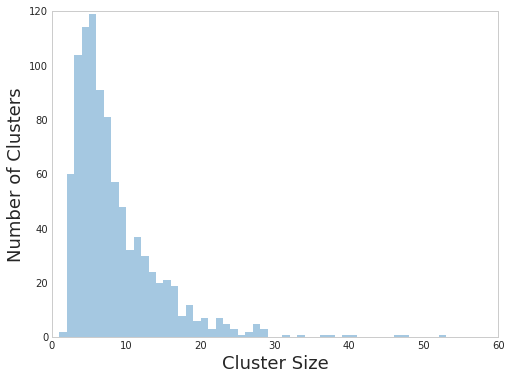

In [25]:
#REMOVE FOR PRODUCTION

import seaborn
%matplotlib inline 
seaborn.set_style("whitegrid")

cluster_stats = (pandas.Series(model.labels_).value_counts().values.tolist())

plt.figure(figsize=(8,6))
seaborn.distplot(cluster_stats, kde = False, bins=range(0,60))
plt.xlim([0,60])
plt.ylim([0,120])
plt.xlabel('Cluster Size', fontdict={'size' : 18})
plt.ylabel('Number of Clusters', fontdict={'size' : 18})
plt.grid()

In [26]:
#Compiled the cluster information into a dataframe
export_clusters = pandas.concat([pandas.DataFrame(cluster_no), pandas.DataFrame(cluster_count) , pandas.DataFrame(cluster_words)], axis=1)
export_clusters.columns = ['cluster_number','count','top_words']

In [27]:
#REMOVE FOR PRODUCTION

pandas.set_option('max_colwidth',80)
export_clusters.head(10)

,cluster_number,count,top_words
0,43,52,"service, hospital_deemed, deemed, deemed_service, staff, documentation, obse..."
1,708,47,"hole, floor, check, corridor, open, open_inch, inch_cable, wall_check, cable..."
2,532,46,"timed, policy_informed, documentation, benefit, transfusion, consent_policy,..."
3,451,40,"indicated, floor, functional, panel_check, nurse_station, required, station,..."
4,913,39,"maintenance_issue, issue, door_pair, positive, room, hardware, positive_latc..."
5,179,37,"unit, medical, program, tracer_activity, activity, related, nursing_plan, tr..."
6,700,36,"critical, panel_check, critical_electrical, floor, room, service, electrical..."
7,81,33,"sterile_room, supply, sterile_supply, storage_room, sterile_processing, proc..."
8,589,31,"chart, norco, dose, mild_pain, mild, tab, moderate_pain, percocet, level, or..."
9,274,28,"administered, mcg, titrate, ordered, morphine, level, pain_score, medication..."


# Post Processing

### Macro Level Analysis - Find Survey over Survery Repeat Issues within Clusters at the Hospital Level

In [28]:
#Limit dataset to HAP
dataset_hap = dataset[dataset.Program_Code.str.strip() == 'HAP'].copy(deep = True)
#dataset_hap retains original index of dataset for mapping

In [29]:
#Identify number of unique surveys per organization
org_set = []

for org_id in dataset_hap.Organization_ID.unique():
    org_set += [(org_id, len(dataset_hap.program_event_id[dataset_hap.Organization_ID == org_id].unique()))]
    
org_set = numpy.array(org_set)

#Remove organizations w/o multiple surveys

org_set = org_set[org_set[:,1]>1]

In [30]:
#Identify clusters that have multiple observations within each organization left over
clstr_index = []
clstr_data = []

for org_id in org_set[:,0]:
    tempinfo = dataset_hap.cluster_id[(dataset_hap.Organization_ID == org_id)].value_counts()
    clstr_index += [org_id]
    clstr_data += [tempinfo[tempinfo > 1].index]

clstr_set = pandas.Series(data = clstr_data, index = clstr_index)
org_set = pandas.Series(data = org_set[:,1], index = org_set[:,0])

In [31]:
#For each org & cluster set, only consider those that with multiple occurances accross surveys
multi_set = []

for org_id in clstr_set.index:
    for clstr_id in clstr_set[org_id]:
        multi_set += [(org_id, clstr_id, len(dataset_hap.program_event_id[(dataset_hap.Organization_ID == org_id) & (dataset_hap.cluster_id == clstr_id)].unique())>1)]
    
multi_set = numpy.array(multi_set)

In [32]:
#Create list of indeicies that should be flagged for multisurvey occurances
flag_index = []

for multi_ocr in multi_set[multi_set[:,2] == 1]:
    flag_index += list(dataset_hap[(dataset_hap.Organization_ID == multi_ocr[0]) & (dataset_hap.cluster_id == multi_ocr[1])].index)

Attach results to observations for Macro Analysis

In [33]:
#Create new column with 0/1 Flag
dataset = dataset.assign(multi_survey_flag = 0)

In [ ]:
#Add multi survey flag data
dataset.multi_survey_flag.loc[flag_index] = 1
sum(dataset.multi_survey_flag)

### Micro Level Analysis - Cosine Similarity

Find Survey over Survery Repeat Issues using similarity measure within each hospital

In [35]:
# Create list of unique organizations by Organization_ID focused on only the HAP program
org_list = []
for org_id in dataset.Organization_ID.unique():
    org_list += [[org_id, len(dataset[(dataset.Organization_ID == org_id) & (dataset.Program_Code.str.strip() == 'HAP')].Survey_Start_Date.unique())]]
    
org_list = numpy.array(org_list)

# Limit the list to those that have had at least 2 surveys
org_list = list(org_list[org_list[:,1]>1][:,0])

In [36]:
# Go through all off the pairs of data and create list of similarities

cos_data = []

for org_id in org_list:

    # Get survey dates
    test_date_A, test_date_B = dataset.Survey_Start_Date[(dataset.Organization_ID == org_id) & (dataset.Program_Code.astype(str) == 'HAP     ')].unique()

    # Get index locations of observations for each survey
    limit_set_A = list(dataset[(dataset.Organization_ID == org_id) & (dataset.Program_Code.astype(str) == 'HAP     ') & (dataset.Survey_Start_Date.astype(str) == test_date_A)].index.values)
    limit_set_B = list(dataset[(dataset.Organization_ID == org_id) & (dataset.Program_Code.astype(str) == 'HAP     ') & (dataset.Survey_Start_Date.astype(str) == test_date_B)].index.values)

    # Get correlation data for the surveys
    limit_data = base_tfidf[limit_set_A,:][:,limit_set_B]
    
    # Convert correlation array to a flat list for consumption by Tableau
    for y in range(0,limit_data.shape[0]):
        for x in range(0,limit_data.shape[1]):
            cos_data += [[org_id,limit_set_A[y],limit_set_B[x], limit_data[y,x]]]

In [37]:
# Convert list to dataframe for better handling
# In theory this is not needed, in practice Tableau needs this to handle the dataset

cos_data = numpy.array(cos_data)

cos_df = pandas.DataFrame()
cos_df['Organization_ID'] = cos_data[:,0].astype(int)
cos_df['Survey_A_idx'] = cos_data[:,1].astype(int)
cos_df['Survey_B_idx'] = cos_data[:,2].astype(int)
cos_df['Cosine_Similarity'] = cos_data[:,3]

In [ ]:
cos_df[cos_df.Cosine_Similarity > 0.5]

In [ ]:
print(dataset.EP_Observations.loc[572], '\n')
print(dataset.EP_Observations.loc[4524])

Set threshold and attach results to observations

In [40]:
#Create new column with 0/1 Flag
dataset = dataset.assign(cosine_similarity_flag = 0)

In [ ]:
# Use a cosine similary threshold greater than ~0.20
# To make sense of the data, we will use 0.25

micro_threshold = 0.25
micro_index = cos_df.Survey_A_idx[cos_df.Cosine_Similarity >= micro_threshold].append(cos_df.Survey_B_idx[cos_df.Cosine_Similarity >= micro_threshold]).unique()
dataset.cosine_similarity_flag.loc[micro_index] = 1

In [42]:
dataset['ref_index'] = dataset.index.values

# Output the data to one consumable file

In [43]:
#Open an excel file for writing
writer = pandas.ExcelWriter('TJC Data Processed.xlsx')

In [44]:
#Pass through survey metadata
#metadata = pandas.read_excel('TJC Data.xlsx', sheetname='OrsSurveyed')  #Passthrough Data
dataset_OrgsSurveyed.to_excel(writer,'OrgsSurveyed',index=False)

#Include Survey Details with cluster assignment, but drop processing data
dataset.drop(labels='EP_Observations_proc', axis=1).to_excel(writer,'StdandEPDetail',index=False)

#Include Survey Details with cluster assignment, but drop processing data
cos_df.to_excel(writer,'Similarity_Analysis',index=False)

#Include details on each cluster
export_clusters.to_excel(writer, 'Cluster_Details', index=False)

In [45]:
#Save the excel file
writer.save()

# Compare the models

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn
seaborn.set_style("whitegrid")

In [47]:
comp_results = pandas.DataFrame(dataset.multi_survey_flag)
comp_results.columns = ['Macro']

In [48]:
micro_threshold = 0.3
comp_results['Micro'] = 0
micro_index = cos_df.Survey_A_idx[cos_df.Cosine_Similarity >= micro_threshold].append(cos_df.Survey_B_idx[cos_df.Cosine_Similarity >= micro_threshold]).unique()
comp_results.Micro.loc[micro_index] = 1

In [49]:
conf = confusion_matrix(comp_results.Macro, comp_results.Micro)

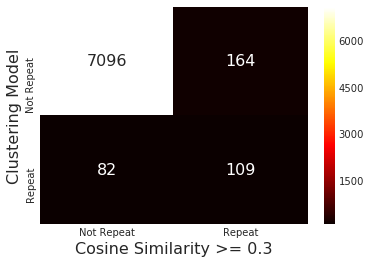

In [50]:
fig = seaborn.heatmap(conf, cmap = 'hot', annot = True,
                      annot_kws={"size": 16}, fmt='d',
                      xticklabels = ['Not Repeat', 'Repeat'], yticklabels = ['Not Repeat', 'Repeat'])
fig.set_xlabel(str('Cosine Similarity >= ' + str(micro_threshold)), size = 16)
fig.set_ylabel('Clustering Model', size = 16)

In [51]:
conf_list = []
conf_thres = []
for x in range(0,100,1):
    micro_threshold = x/100
    comp_results['Micro'] = 0
    micro_index = cos_df.Survey_A_idx[cos_df.Cosine_Similarity >= micro_threshold].append(cos_df.Survey_B_idx[cos_df.Cosine_Similarity >= micro_threshold]).unique()
    comp_results.Micro.loc[micro_index] = 1
    
    conf_thres += [micro_threshold]
    conf_list += [confusion_matrix(comp_results.Macro, comp_results.Micro)]
    
conf_list = numpy.array(conf_list)

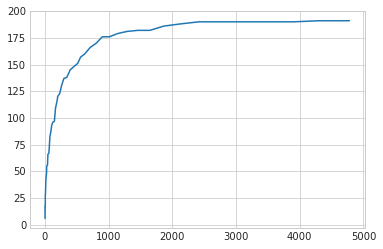

In [53]:
tp = conf_list[:,1,1]
fp = conf_list[:,0,1]
plt.plot(fp,tp)